<a href="https://colab.research.google.com/github/letruong711/Neural-Networks-and-Pneumonia/blob/main/Pneumonia_and_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Importing libraries.**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

import os
import glob
import random

import keras

from keras.models import Sequential
from keras.layers import Dense
from keras.datasets import mnist
from keras.models import load_model
from keras.wrappers.scikit_learn import KerasClassifier

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, Flatten, Dropout, MaxPool2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras import optimizers

import datetime

import talos

# Importing data.

#### Followed https://www.youtube.com/watch?v=n4mxwSAWvo8&t=364s&ab_channel=DrJuanKlopper to help import library into Google Collab.

In [ ]:
#setting up bridge between collab and drive
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

In [ ]:
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
fid = drive.ListFile({'q': "title='archive.zip'"}).GetList()[0]['id']
f = drive.CreateFile({'id':fid})
f.GetContentFile('archive.zip')

In [ ]:
#unzip massive file.
!unzip archive.zip

In [ ]:
PATH = '/content/chest_xray'

In [ ]:
os.listdir(PATH)

['val', '__MACOSX', 'train', 'chest_xray', 'test']

In [ ]:
train_dir = os.path.join(PATH, 'train')
test_dir = os.path.join(PATH, 'test')
val_dir = os.path.join(PATH, 'val')

In [ ]:
#train_normal_dir = os.path.join(train_dir, 'NORMAL')
#train_pneumonia_dir = os.path.join(train_dir, 'PNEUMONIA')


#test_normal_dir = os.path.join(test_dir, 'NORMAL')
#test_pneumonia_dir = os.path.join(test_dir, 'PNEUMONIA')

# **Preprocessing.**

In [ ]:
IMG_HEIGHT = 224
IMG_WIDTH = 224
batch_size = 624

In [ ]:
image_gen = ImageDataGenerator()

# **Visualizing our Loss and Accuracy Curves.**

In [ ]:
def visualize_training_results(results):
    history = results.history
    plt.figure()
    plt.plot(history['val_loss'])
    plt.plot(history['loss'])
    plt.legend(['val_loss', 'loss'])
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.show()
    
    plt.figure()
    plt.plot(history['val_accuracy'])
    plt.plot(history['accuracy'])
    plt.legend(['val_acc_accuracy', 'accuracy'])
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.show()


# **CNN**.

In [ ]:
#IMG_HEIGHT = 224
#IMG_WIDTH = 224
#batch_size = 624

In [ ]:
#train_dir = os.path.join(PATH, 'train')
#test_dir = os.path.join(PATH, 'test')
#val_dir = os.path.join(PATH, 'val')

In [ ]:
image_gen = ImageDataGenerator(rescale = 1./255)

In [ ]:
train_data_gen = image_gen.flow_from_directory(
    directory=train_dir,
    shuffle=True,
    target_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size= 5216,
    class_mode='binary')

Found 5216 images belonging to 2 classes.


In [ ]:
test_data_gen = image_gen.flow_from_directory(
    directory = test_dir,
    target_size = (IMG_HEIGHT, IMG_WIDTH),
    batch_size = batch_size,
    class_mode='binary')

Found 624 images belonging to 2 classes.


In [ ]:
cnn_train_images, cnn_train_labels = next(train_data_gen)
cnn_test_images, cnn_test_labels = next(test_data_gen)

In [ ]:
display(np.shape(cnn_train_images))
display(np.shape(cnn_train_labels))
display(type(cnn_train_images))
display(type(cnn_train_labels))

display(np.shape(cnn_test_images))
display(np.shape(cnn_test_labels))
display(type(cnn_test_images))
display(type(cnn_test_labels))

(5216, 224, 224, 3)

(5216,)

numpy.ndarray

numpy.ndarray

(624, 224, 224, 3)

(624,)

numpy.ndarray

numpy.ndarray

In [ ]:
#creating the model
def initialize_model():
    model = Sequential()
    model.add(layers.Conv2D(32, (3, 3), activation="relu", input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(64, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(2, 2)))
    model.add(layers.Conv2D(128, (3, 3), activation="relu", padding='same'))
    model.add(layers.MaxPool2D(pool_size=(3, 3)))
    model.add(layers.Flatten())
    model.add(layers.Dense(120, activation='relu'))
    model.add(layers.Dense(60, activation='relu'))
    model.add(layers.Dropout(rate=0.2))
    model.add(layers.Dense(1, activation='sigmoid'))

    return model

In [ ]:
cnn = initialize_model()

In [ ]:
#compile it
cnn.compile(loss = 'binary_crossentropy', optimizer='adam', metrics = ['accuracy'])

In [ ]:
cnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 224, 224, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 32)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 64)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 56, 56, 128)       73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 18, 18, 128)      0

In [ ]:
#run the model
history = cnn.fit(cnn_train_images,
                    cnn_train_labels,
                    epochs=200,
                    batch_size=50,
                    validation_data=(cnn_test_images, cnn_test_labels))

Epoch 1/200
105/105 [==============================] - 152s 1s/step - loss: 0.2739 - accuracy: 0.8857 - val_loss: 0.5581 - val_accuracy: 0.7965
Epoch 2/200
105/105 [==============================] - 150s 1s/step - loss: 0.0973 - accuracy: 0.9643 - val_loss: 0.7141 - val_accuracy: 0.7724
Epoch 3/200
105/105 [==============================] - 150s 1s/step - loss: 0.0735 - accuracy: 0.9722 - val_loss: 0.9131 - val_accuracy: 0.7548
Epoch 4/200
105/105 [==============================] - 150s 1s/step - loss: 0.0532 - accuracy: 0.9818 - val_loss: 1.2123 - val_accuracy: 0.7596
Epoch 5/200
105/105 [==============================] - 150s 1s/step - loss: 0.0406 - accuracy: 0.9862 - val_loss: 1.1954 - val_accuracy: 0.7756
Epoch 6/200
105/105 [==============================] - 149s 1s/step - loss: 0.0384 - accuracy: 0.9862 - val_loss: 1.0694 - val_accuracy: 0.7885
Epoch 7/200
105/105 [==============================] - 149s 1s/step - loss: 0.0280 - accuracy: 0.9902 - val_loss: 2.3794 - val_accuracy:

In [ ]:
cnn_scores = cnn.evaluate(cnn_test_images, cnn_test_labels, verbose=2)
cnn_scores

20/20 - 4s - loss: 8.9707 - accuracy: 0.7308 - 4s/epoch - 193ms/step


[8.970744132995605, 0.7307692170143127]

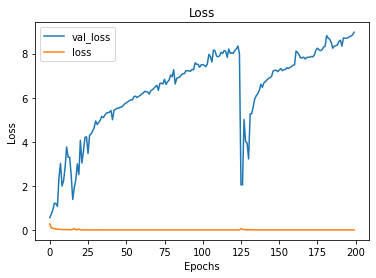

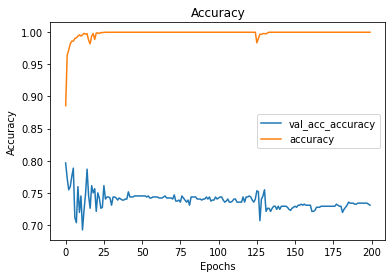

In [ ]:
visualize_training_results(history)

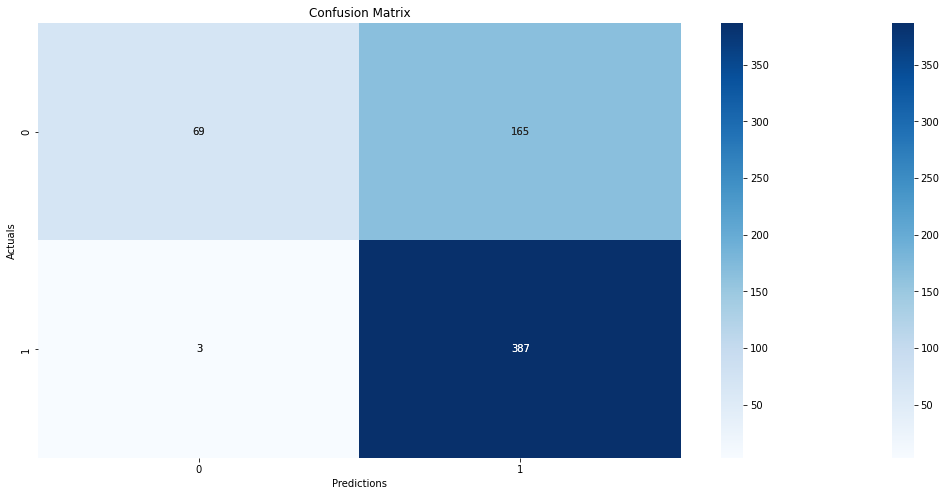

In [ ]:
#normal = 0, pneumonia = 1
fig, ax = plt.subplots(figsize=(18, 8))
y_hat_test = cnn.predict(cnn_test_images)
thresh = 0.5
y_pred = (y_hat_test > thresh).astype(np.int)
y_true = cnn_test_labels.astype(np.int)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot = True, cmap = 'Blues', fmt = '0.5g')
sns.heatmap(cm, annot = True, cmap = 'Blues', fmt = '0.5g')
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
print(classification_report(y_true, y_pred))

              precision    recall  f1-score   support

           0       0.96      0.29      0.45       234
           1       0.70      0.99      0.82       390

    accuracy                           0.73       624
   macro avg       0.83      0.64      0.64       624
weighted avg       0.80      0.73      0.68       624



In [ ]:
!mkdir -p saved_model
cnn.save('cnn.h5')
cnn.save_weights('model_weights.h5')

In [ ]:
my_model = load_model('cnn.h5')
my_model.load_weights('model_weights.h5')

# **Baseline CNN Results.**

- Baseline model with no parameters gave us a 73% accuracy rate.
- Model accuracy doesn't show improvement after 20 epochs.
- Model showed a large amount of overfitting.
- This model could be improved/tuned by using differnet activation functions, trying different optimizers, and different degrees of dropouts.
- Confusion Matrix showed a lot of false negatives.

# **Tuned CNN**.

In [ ]:
model = Sequential()
model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=(IMG_HEIGHT, IMG_WIDTH, 3), padding='same'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Conv2D(64, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(2, 2)))
model.add(layers.Conv2D(128, (3, 3), activation='relu', padding='same'))
model.add(layers.MaxPool2D(pool_size=(3, 3)))
model.add(layers.Flatten())
model.add(layers.Dense(120, activation='relu'))
model.add(layers.Dense(60, activation='relu'))
model.add(layers.Dropout(.1))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics='accuracy')
es = EarlyStopping(patience=15, monitor= 'val_accuracy', restore_best_weights=True)

tuned_cnn = model.fit(cnn_train_images, 
            cnn_train_labels,
            batch_size = 50,
            epochs = 200,
            validation_data=(cnn_test_images, cnn_test_labels),
            callbacks = es)

Epoch 1/200
105/105 [==============================] - 157s 1s/step - loss: 0.2422 - accuracy: 0.9024 - val_loss: 0.6682 - val_accuracy: 0.7869
Epoch 2/200
105/105 [==============================] - 156s 1s/step - loss: 0.1073 - accuracy: 0.9590 - val_loss: 0.7458 - val_accuracy: 0.7420
Epoch 3/200
105/105 [==============================] - 153s 1s/step - loss: 0.0832 - accuracy: 0.9672 - val_loss: 1.2878 - val_accuracy: 0.7035
Epoch 4/200
105/105 [==============================] - 154s 1s/step - loss: 0.0507 - accuracy: 0.9810 - val_loss: 1.0838 - val_accuracy: 0.7821
Epoch 5/200
105/105 [==============================] - 153s 1s/step - loss: 0.0496 - accuracy: 0.9816 - val_loss: 1.6724 - val_accuracy: 0.7212
Epoch 6/200
105/105 [==============================] - 152s 1s/step - loss: 0.0335 - accuracy: 0.9858 - val_loss: 1.9200 - val_accuracy: 0.7179
Epoch 7/200
105/105 [==============================] - 153s 1s/step - loss: 0.0243 - accuracy: 0.9916 - val_loss: 1.5262 - val_accuracy:

In [ ]:
!mkdir -p saved_model
model.save('tuned_cnn.h5')
model.save_weights('tuned_cnn.weights.h5')

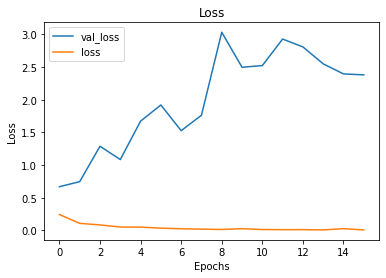

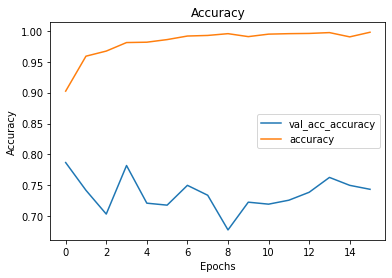

In [ ]:
visualize_training_results(tuned_cnn)

In [ ]:
cnn_scores = model.evaluate(cnn_test_images, cnn_test_labels, verbose=2)
cnn_scores

20/20 - 4s - loss: 0.6682 - accuracy: 0.7869 - 4s/epoch - 193ms/step


[0.668186604976654, 0.7868589758872986]

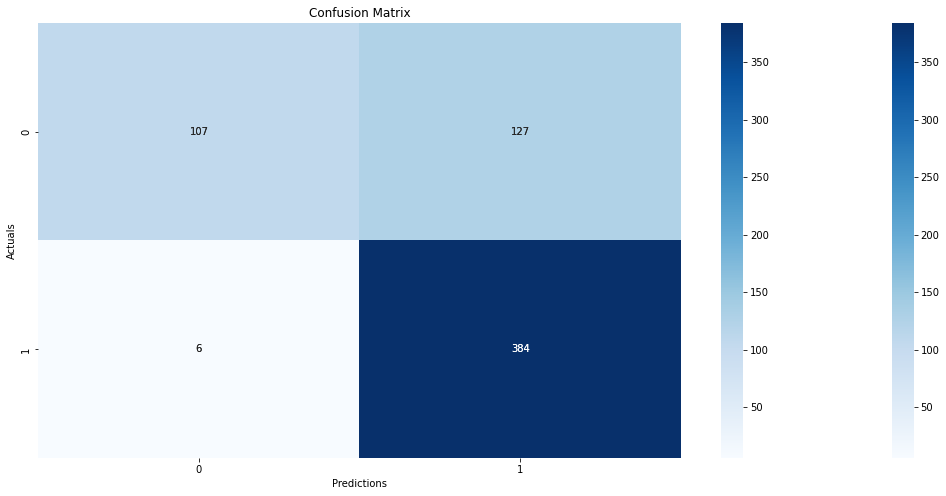

In [ ]:
#normal = 0, pneumonia = 1
fig, ax = plt.subplots(figsize=(18, 8))
y_hat_test = model.predict(cnn_test_images)
thresh = 0.5
y_pred = (y_hat_test > thresh).astype(np.int)
y_true = cnn_test_labels.astype(np.int)
cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot = True, cmap = 'Blues', fmt = '0.5g')
sns.heatmap(cm, annot = True, cmap = 'Blues', fmt = '0.5g')
plt.xlabel('Predictions')
plt.ylabel('Actuals')
plt.title('Confusion Matrix')
plt.show()

# **Tuned CNN Results.**

- Tuning the CNN with early stopping and a lower droprate increased our accuracy to 79%.
- Unable to produce accuracy report as notebook timed out and forced reset our models. Will not repeat as accuracy showed the same as the recall rate on previous models. 
- Still shows signs of overfitting.
- Our early stop stopped the model at 16 epochs stating that the model will not improve after that number of epochs.
- Possible to increase accuracy if we change the learning rate and modified droprate sooner. 